# 4D Post-stack seismic Inversion of synthetic VTI Hess

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from pylops.basicoperators import *
from pylops import Laplacian, VStack, HStack, Identity, FirstDerivative
from pylops.utils.wavelets import ricker
from pylops.avo.poststack import PoststackLinearModelling
from pylops.optimization.leastsquares import regularized_inversion as RegularizedInversion
from pyproximal.proximal import L2, L21
from pyproximal.optimization.segmentation import PrimalDual
from prox4d.utils_ import *
from prox4d.jointinv4D import jis_4D

plt.rcParams['font.size'] = '13'

## Data loading

In [3]:
rre = {}
snr = {}

# data Loading
dn2 = np.load('../data/Hess/Hess_seismic_monitor.npy')
dn1 = np.load('../data/Hess/Hess_seismic_baseline.npy')
m1 = np.log(np.load('../data/Hess/Hess_impedance_baseline.npy'))
m2 = np.log(np.load('../data/Hess/Hess_impedance_monitor.npy'))
mback = np.log(np.load('../data/Hess/Hess_background_model.npy'))
vmin, vmax = m1.min(), m1.max()

# Create the forward operator
nt0, nx = [395, 905]
dt0 = 0.008
t0 = np.arange(nt0) * dt0
dx = 4
ntwav = 61
wav, twav, wavc = ricker(t0[:ntwav // 2 + 1], 8)
Lop = PoststackLinearModelling(wav / 2, nt0=nt0, spatdims=nx)

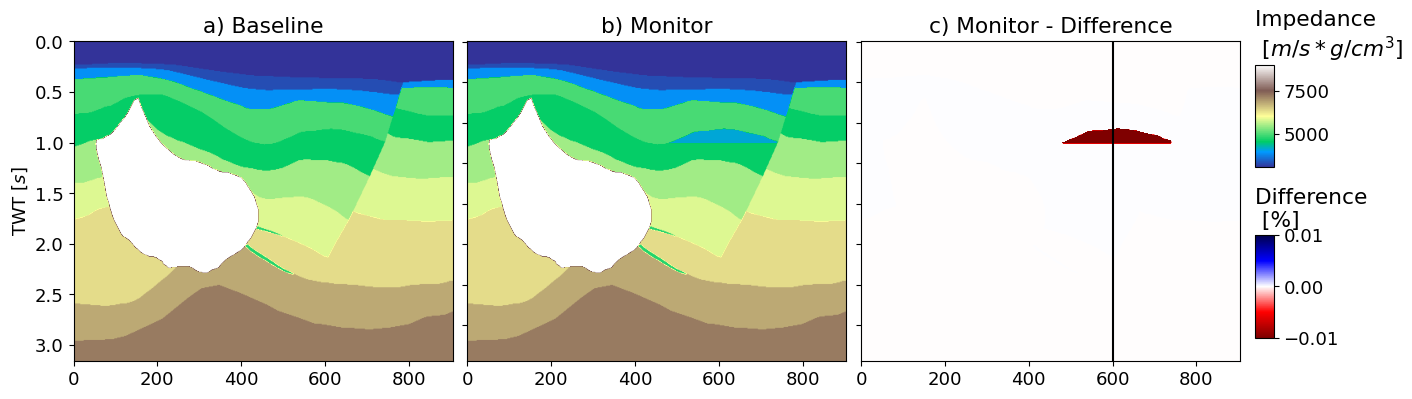

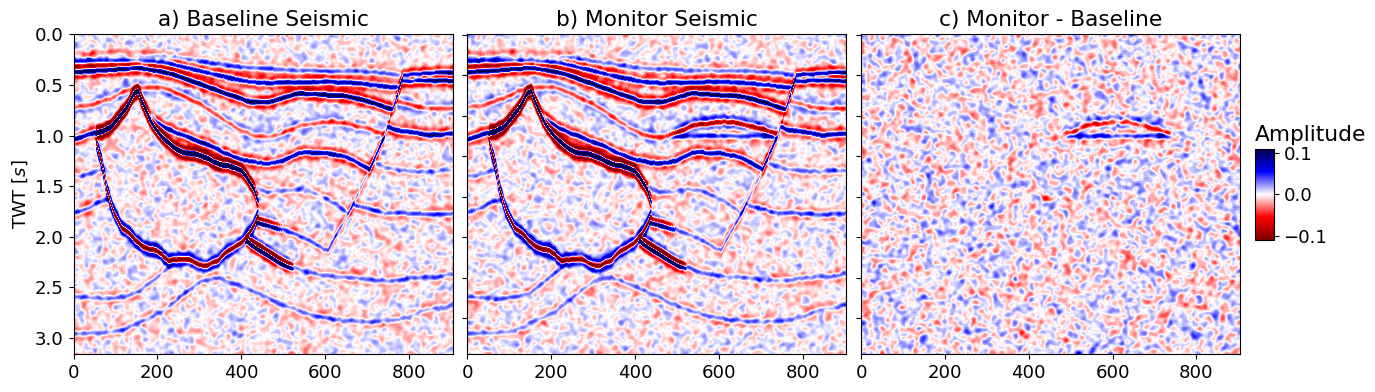

In [14]:
plotter_4D(np.exp(m1), np.exp(m2), dt=dt0, vline=600)
# plt.savefig('../figures/Hess_impedance.png', bbox_inches='tight')
plotter_4D(dn1, dn2, type='seismic', dt=dt0)
# plt.savefig('../figures/Hess_seismic.png', bbox_inches='tight')

## Approach 1: L2-Reg Inversion with model difference as a coupling term

\begin{equation}
    \frac{1}{2} \left\Vert\left[\begin{array}{ll}
    G_1 & 0 \\
    0 & G_2 \\
    \end{array}\right]
    \left[\begin{array}{ll}
    m_1  \\
    m_2  \\
    \end{array}\right]
     - \left[\begin{array}{ll}
    d_1  \\
    d_2 
    \end{array}\right]
    \right\Vert_2^2
    + \lambda
    \left\Vert
    \begin{array}{ll}
    m_1  \\
    m_2  \\
    \end{array}
    \right\Vert_2^2
    + \epsilon
    \left\Vert\left[\begin{array}{ll}
    \nabla^2 & 0 \\
    0 & \nabla^2\\
    \end{array}\right]
    \left[\begin{array}{ll}
    m_1  \\
    m_2  \\
    \end{array}\right]
    \right\Vert_2^2
    + \lambda\alpha
    \left\Vert
    m_2 - m_1
    \right\Vert^2_2
\end{equation}

In [5]:
alpha = 0.1
id = Identity(int(nx * nt0), int(nx * nt0))
ID = HStack([-id * alpha, id * alpha])
LOP = BlockDiag([Lop, Lop])
LOP2 = VStack([LOP, ID])
Dop = Laplacian(dims=(nt0, nx), dtype=Lop.dtype)
DOP = BlockDiag([Dop, Dop])
MBACK = np.hstack([mback.ravel(), mback.ravel()])
DN = np.hstack([dn1.ravel(), dn2.ravel()])
DN2 = np.hstack([dn1.ravel(), dn2.ravel(), np.zeros(nt0 * nx)])
DOP.shape, LOP2.shape, DN2.shape, MBACK.shape

# L2 regularized inversion
ml2 = RegularizedInversion(LOP2, DN2, [DOP],
                           x0=MBACK, epsRs=[1.], show=False,
                           **dict(iter_lim=100, damp=1e-1))[0]

ml2a = np.exp(ml2[:ml2.shape[0]//2].reshape(nt0, nx))
ml2b = np.exp(ml2[ml2.shape[0]//2:].reshape(nt0, nx))

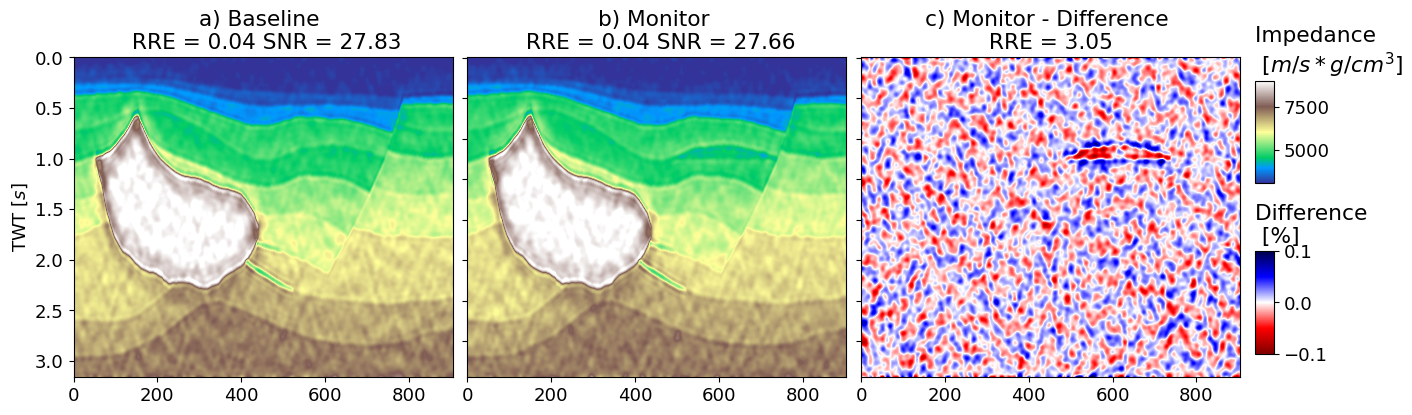

In [15]:
plotter_4D(ml2a, ml2b, dt=dt0, dif_scale=0.1, ref=np.exp(m1), mtrue=[np.exp(m1), np.exp(m2)])
# plt.savefig('../../figures/Hess_4Djointl2inversion.png', bbox_inches='tight')

## Approach 2: TV-Reg Inversion with model difference as a coupling term

\begin{equation}
    \frac{1}{2} \left\Vert\left[\begin{array}{ll}
    G_1 & 0 \\
    0 & G_2 \\
    \end{array}\right]
    \left[\begin{array}{ll}
    m_1  \\
    m_2  \\
    \end{array}\right]
     - \left[\begin{array}{ll}
    d_1  \\
    d_2  \\
    \end{array}\right]
    \right\Vert_2^2
    + \sigma
    \left\Vert
    \begin{array}{ll}
    m_1  \\
    m_2  \\
    \end{array}
    \right\Vert_{TV}
     + \sigma \alpha
    \left\Vert
    m_2 - m_1
    \right\Vert_{TV}
\end{equation}

In [7]:
# Primal-dual (Blockiness-promoting inversion with isotropic TV)

l2_2 = L2(Op=LOP, b=DN, niter=20, warm=True)
Dzop = FirstDerivative(dims=(nt0, nx), axis=0, edge=True, dtype=Lop.dtype, kind='forward')
Dxop = FirstDerivative(dims=(nt0, nx), axis=1, edge=True, dtype=Lop.dtype, kind='forward')
Zop = Zero(nx * nt0, dtype='float64')
sigma = 0.01
alpha = .8
DOP = Block([[Dzop, Zop],
             [Zop, Dzop],
             [alpha * Dzop, -alpha * Dzop],
             [Dxop, Zop],
             [Zop, Dxop],
             [alpha * Dxop, -alpha * Dxop]])
l21 = L21(ndim=2, sigma=sigma)

L = 16.  # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)
mtv = PrimalDual(l2_2, l21, DOP, MBACK, tau=tau, mu=mu,
                 theta=1., niter=100, show=True)

mtva = np.exp(mtv[:mtv.shape[0]//2].reshape(nt0, nx))
mtvb = np.exp(mtv[mtv.shape[0]//2:].reshape(nt0, nx))

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.block.Block'>
Additional vector (z): None
tau = 1.0		mu = 0.061875
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   8.02527e+00   1.073e+02   4.240e+01   0.000e+00       1.497e+02
     2   8.02877e+00   5.137e+01   5.478e+01   0.000e+00       1.061e+02
     3   8.03126e+00   3.531e+01   6.015e+01   0.000e+00       9.546e+01
     4   8.03208e+00   2.866e+01   6.232e+01   0.000e+00       9.098e+01
     5   8.03123e+00   2.511e+01   6.299e+01   0.000e+00       8.810e+01
     6   8.02915e+00   2.293e+01   6.288e+01   0.000e+00       8.581e+01
     7   8.02643e+00   2.147e+01   6.240e+01   0.000e+00       8.386e+01
     8   8.02366e+00   2.044e+01   6.175e+01   0.0

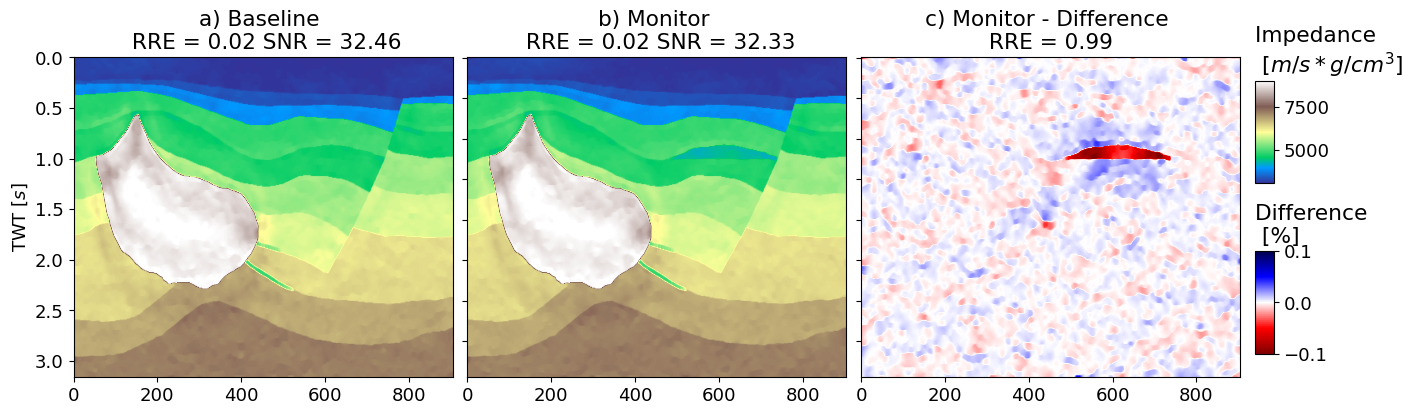

In [16]:
plotter_4D(mtva, mtvb, dt=dt0, dif_scale=0.1, ref=np.exp(m1), mtrue=[np.exp(m1), np.exp(m2)])
# plt.savefig('../../figures/Hess_4DjointTVinversion.png', bbox_inches='tight')

## Approach 3: Joint Inversion and Segmentation with TV-Reg

\begin{equation}
    \frac{1}{2} \left\Vert\left[\begin{array}{ll}
    G_1 & 0 \\
    0 & G_2 \\
    \end{array}\right]
    \left[\begin{array}{ll}
    m_1  \\
    m_2  \\
    \end{array}\right]
     - \left[\begin{array}{ll}
    d_1  \\
    d_2  \\
    \end{array}\right]
    \right\Vert_2^2
    + \alpha
    \left\Vert
    \begin{array}{ll}
     m_1  \\
     m_2  \\
    \end{array}
    \right\Vert_{TV_{aniso}}
    +
    \delta \sum_{j=1}^{N_c} \sum_{i=1}^{N_x N_z}  V_{ji} ((m_2-m_1) - c_j)^2 +\beta \sum_{j=1}^{N_c} \left\Vert V^T_j \right\Vert_{TV}
\end{equation}

Working with alpha=0.030000,  beta=0.050000,  delta=10.000000
Iteration 0...
f= 33.515034259870845
||v-v_old||_2= 597.4883172166533
||m-m_old||_2= 42.28914328888158
Iteration 1...
f= 26.882805852498425
||v-v_old||_2= 13.82502655831895
||m-m_old||_2= 11.523758442574355
Iteration 2...
f= 24.93634734637282
||v-v_old||_2= 3.4283005682963923
||m-m_old||_2= 4.064431332506444


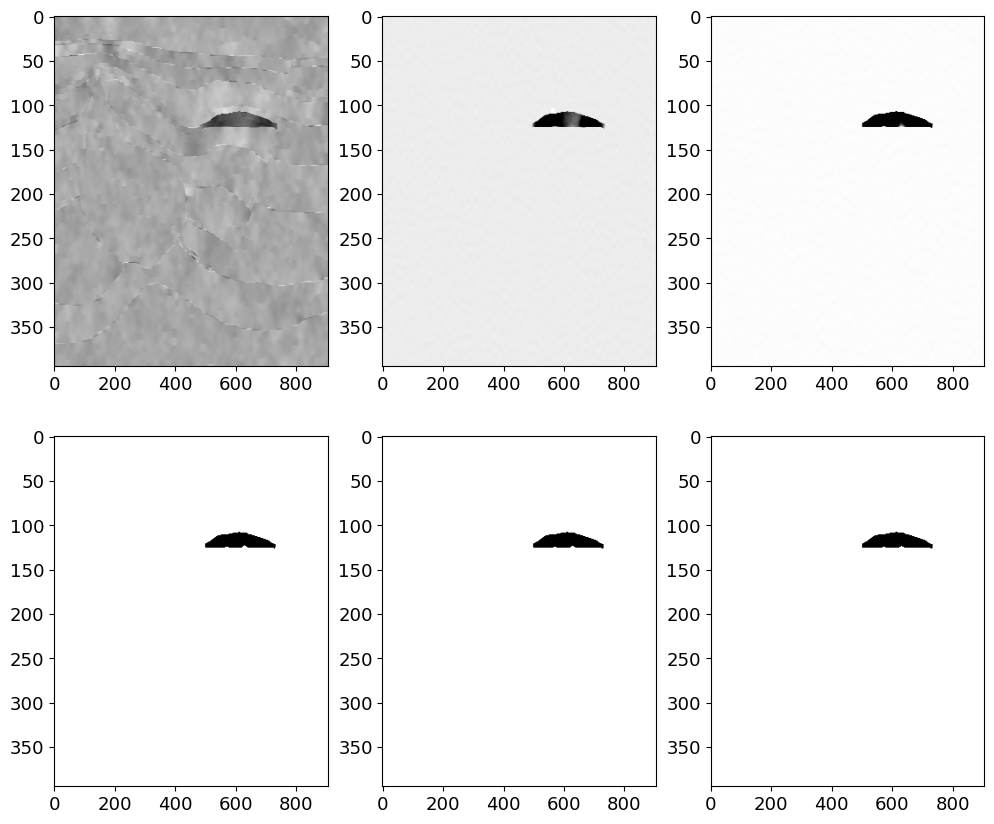

In [9]:
# Parameters
# alpha=0.030000,  beta=0.050000,  delta=10.000000
cl = np.array([-0.1, 0, 0.1])
alpha = 0.03
beta = 0.05
delta = 10.

niter = 3
tolstop = 0.

L = 8.  # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)
model_TV = 'anisotropic'

mjoint, vjoint, vcljoint, rre_, snr_, mjoint_hist, vjoint_hist = jis_4D(dn1, dn2, mback, cl,
                                                                        Lop, Lop, model_TV,
                                                                        alpha, beta, delta,
                                                                        tau, mu,
                                                                        niter=niter,
                                                                        l2niter=20,
                                                                        pdniter=100,
                                                                        segmentniter=40,
                                                                        bisectniter=10,
                                                                        tolstop=tolstop,
                                                                        mtrue=[m1, m2],
                                                                        plotflag=True,
                                                                        show=False)

mjointa = np.exp(mjoint[:mjoint.shape[0]//2].reshape(nt0, nx))
mjointb = np.exp(mjoint[mjoint.shape[0]//2:].reshape(nt0, nx))

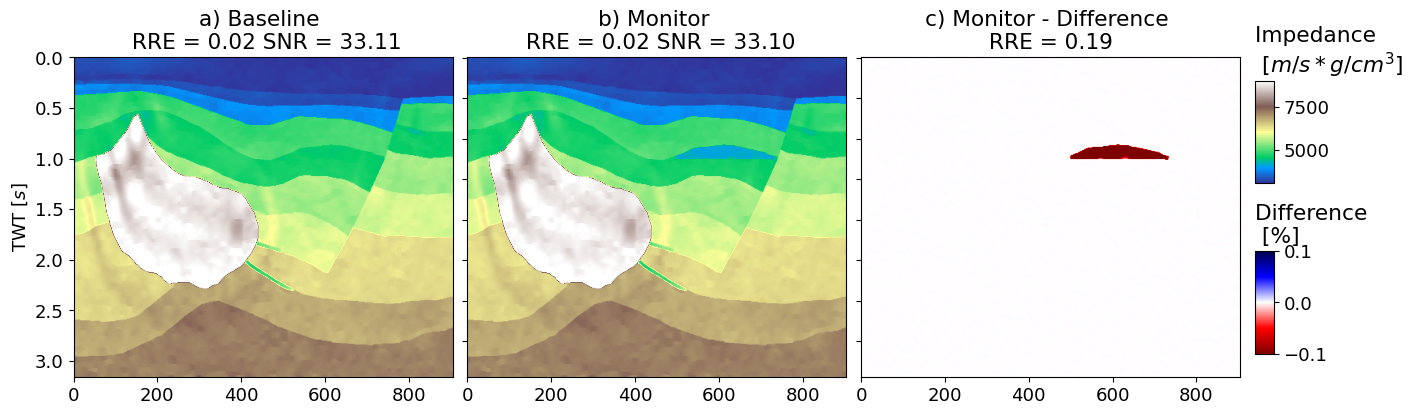

In [17]:
# Inversion results
plotter_4D(mjointa, mjointb, dt=dt0, dif_scale=0.1, ref=np.exp(m1), mtrue=[np.exp(m1), np.exp(m2)])
# plt.savefig('../../figures/Hess_4DJIS.png', bbox_inches='tight')

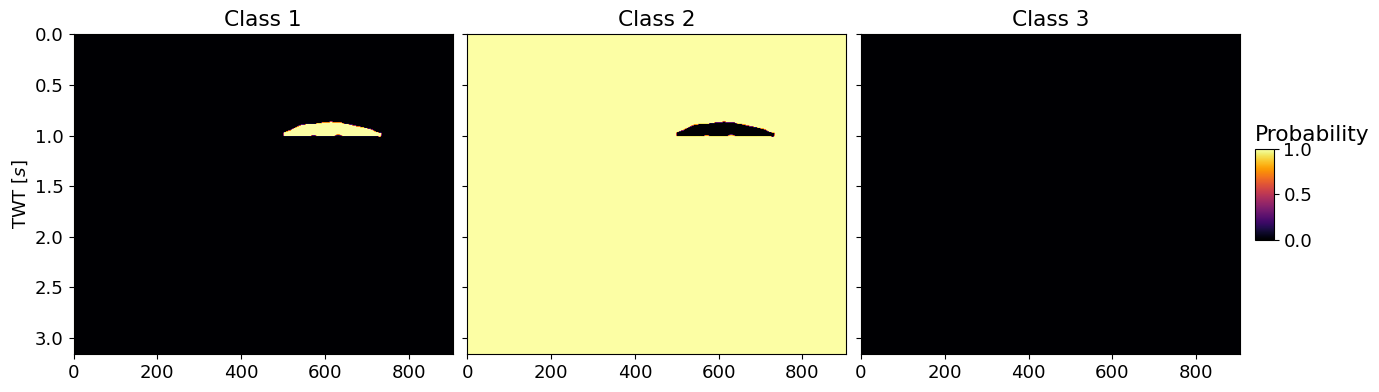

In [11]:
# Segmentation results
plotter_4D_seg(vjoint, nt0, nx, dt=dt0)
# plt.savefig('../../figures/Hess_4DJIS_seg.png', bbox_inches='tight')

## 1D Comparison

Text(0, 0.5, 'TWT [S]')

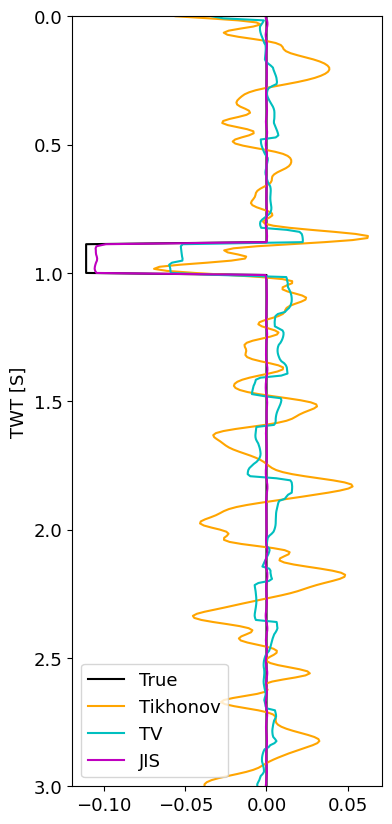

In [13]:
t = (np.arange(m1.shape[0]) * dt0)
fig, axes = plt.subplots(figsize=(4, 10), sharey=True)
axes.plot(((np.exp(m2) - np.exp(m1)) / np.exp(m2))[:, 650], t, 'k', label='True')
axes.plot(((ml2b - ml2a) / ml2b)[:, 650], t, 'orange', label='Tikhonov')
axes.plot(((mtvb - mtva) / mtvb)[:, 650], t, 'c', label='TV')
axes.plot(((mjointb - mjointa) / mjointb)[:, 650], t, 'm', label='JIS')
axes.set_ylim(3, 0)
axes.legend()
axes.set_ylabel('TWT [S]')
# plt.savefig('../../figures/Hess_profile.png', bbox_inches='tight')